In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils.metrics import UnbiasedExponentialMovingAverage as uema

In [2]:
data_path = os.path.dirname(os.path.abspath("")) + '/analysis/plant_data/old/reprocessed.csv'
full_df = pd.read_csv(data_path)

In [3]:
# Remove night time
import datetime
full_df['time'] = pd.to_datetime(full_df['time'])
full_df['time_only'] = full_df['time'].dt.time
start_time = datetime.time(9, 25)
end_time = datetime.time(20, 45)
df = full_df[(full_df['time_only'] >= start_time) & (full_df['time_only'] <= end_time)]

In [4]:
areas = df['clean_area'].to_numpy()
areas = np.reshape(areas, (-1,56))  # needed for standard*.csv

In [5]:
area = np.array([np.mean(areas[i,:]) for i in range(areas.shape[0])])

In [6]:
area_trace = uema(alpha=0.01)
area_trace.update(area[0])
smooth_area = [area_trace.compute().item()]
r1 = np.hstack([[0], np.diff(area)])
r2 = []
r3 = []
m = 18
for i in range(1, len(area)):
    area_trace.update(area[i])
    smooth_area.append(area_trace.compute().item())

    if i % m == 0 and i >= 2*m:
        r2.append(np.mean(area[i-m:i]) - np.mean(area[i-m*2:i-m]))
        r3.append(smooth_area[-1] - smooth_area[-1-m])
    else: 
        r2.append(0)
        r3.append(0)
    
r2 = np.array(r2)
r3 = np.array(r3)

def R(x):
    return np.flip(np.cumsum(np.flip(x)))

Text(0.5, 0, 'Daytime Time Step')

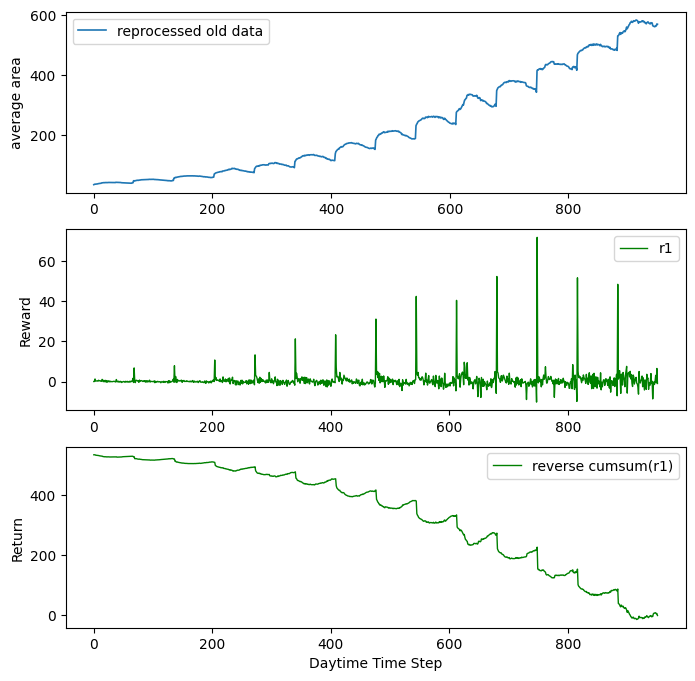

In [7]:
fig, ax = plt.subplots(3,1, figsize=(8,8))
ax[0].plot(area[1:], linewidth=1.2, label='reprocessed old data')
ax[0].legend()
ax[0].set_ylabel('average area')
ax[1].plot(r1, 'g', linewidth=1, alpha=1, label='r1')
#ax[1].plot(r2, 'r', linewidth=1,alpha=0.7, label='r2')
ax[1].legend()
ax[1].set_ylabel('Reward')
#ax[1].set_ylim(-20,20)
ax[2].plot(R(r1), 'g', linewidth=1, alpha=1,label='reverse cumsum(r1)')
#ax[2].plot(R(r2), 'r', linewidth=1, alpha=0.7,label='reverse cumsum(r2)')
ax[2].legend()
ax[2].set_ylabel('Return')
ax[2].set_xlabel('Daytime Time Step')